# Data Fitting and Least Action Principle

## Introduction

As discsussed in the note, data fitting and the least action principle are equivalent. In this notebook, we explore this equivalence by considering the dynamics of oscillators. We are to reveal the true action from the raw data.

## Configurations

To challange our theory, we consider an oscillator a little more complex than the harmonic oscillator. The dynamcs is given by the differential equation:

$$ \ddot{x} = -g_1 x - \frac{g_3}{3!} x^3 - \frac{g_5}{5!} x^5 - \cdots. $$

On the right hand side, only odd terms involved. This is for ensuring the parity symmetry. The couplings $(g_1, g_3, \ldots)$ shall be finite of course. In this experiment, we give the target couplings, the `TARGET_COUPLINGS`. And with these couplings, simulation data are generated by numerically solving the differential equation of the dynamics. The simulation starts at time `0` and ends at the `MAX_TIME`. By randomly initializing position and velocity, `DATA_SIZE` simulation data are generated. In real world, measurement errors are inevitable. We also consider adding a Gaussian error with std `MEASUREMENT_ERROR_STD` to the simulaiton data.

In [1]:
# TARGET_COUPLINGS = [10.]
TARGET_COUPLINGS = [10., 20]
NUM_FRAMES = 501
MAX_TIME = 10.
DATA_SIZE = 10**4
BATCH_SIZE = 128
TEST_SIZE = 200  # data for evaluation.
MEASUREMENT_ERROR_STD = 0.  # no measurement errors.
# MEASUREMENT_ERROR_STD = 3e-2

In [2]:
import math
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python import keras

## Data Generation

In [3]:
def oscillator_ode(y, t):
    x, v = y
    dx = v
    dv = -sum(g / math.factorial(2*i+1) * x**(2*i+1)
              for i, g in enumerate(TARGET_COUPLINGS))
    return [dx, dv]

In [4]:
%%time
time_span = np.linspace(0, MAX_TIME, NUM_FRAMES)
raw_data = np.zeros([DATA_SIZE, NUM_FRAMES, 2])  # initialize.
for i in range(DATA_SIZE):
    # Randomly initialize the position and the velocity
    x_init = np.random.uniform(low=-1, high=1)
    v_init = np.random.uniform(low=-1, high=1)

    sol = odeint(oscillator_ode, [x_init, v_init], time_span)
    raw_data[i, :, :] =  sol

# Add measurement errors
measure_err = np.random.normal(scale=MEASUREMENT_ERROR_STD, size=raw_data.shape)
data = raw_data + measure_err

CPU times: user 34.9 s, sys: 434 ms, total: 35.3 s
Wall time: 45.6 s


Let us show an instance.

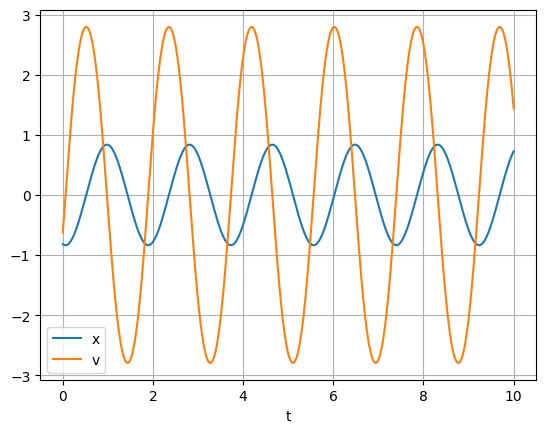

In [5]:
plt.plot(time_span, data[0, :, 0], label='x')
plt.plot(time_span, data[0, :, 1], label='v')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

Convert to `tf.data.Dataset` protocol.

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices(data[TEST_SIZE:, :, 0].astype('float32'))

We use the first `TEST_SIZE` data for evaluation.

In [7]:
eval_data = tf.convert_to_tensor(data[:TEST_SIZE, :, 0], dtype=tf.float32)

## Model

The action is assumed to be

$$ S(x; g) = \frac{1}{2} \dot{x}^2 - \frac{g_2}{2!} x^2 - \frac{g_4}{4!} x^4 - \cdots, $$

where the collection $g := (g_2, g_4, \ldots)$ which has finite elements are to be trained to fit the data. Only even terms appear in the potential for ensuring parity symmetry. In addition, the action is local and time-independent. The $\dot{x}$ is computed by difference.

In [8]:
class Action(keras.Model):

    def __init__(self, couplings):
        super().__init__()
        self.couplings = couplings

    def call(self, xs, ts):
        # Kinetic term:
        dx = xs[:, 1:] - xs[:, :-1]
        dt = ts[:, 1:] - ts[:, :-1]
        action_value = 0.5 * tf.reduce_mean(tf.square(dx / dt), axis=1)
        # Potential term
        for i, g in enumerate(self.couplings):
            action_value -= (
                g / math.factorial(2*i+2) *
                tf.reduce_mean(tf.pow(xs, 2*i+2), axis=1)
            )
        return action_value

model = Action([tf.Variable(0.), tf.Variable(0.), tf.Variable(0.)])

In [9]:
xs = tf.convert_to_tensor(data[:BATCH_SIZE, :, 0], dtype=tf.float32)  # for debugging code.
ts = tf.convert_to_tensor(time_span[np.newaxis, :], dtype=tf.float32)

In [10]:
model(xs, ts)  # build the model.

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([2.0405042 , 2.9579809 , 2.1365926 , 0.51765686, 0.04726647,
       0.40134242, 0.96873605, 3.2136211 , 3.1357229 , 0.3227118 ,
       1.2451663 , 2.8505445 , 0.85241896, 2.3751676 , 0.20267305,
       0.5492407 , 1.9946216 , 0.63157725, 0.15962872, 0.00394523,
       0.1214889 , 0.10049569, 0.86615443, 0.38261208, 0.05794985,
       0.22006886, 1.093262  , 2.1913152 , 1.9388064 , 2.8247554 ,
       2.550337  , 0.6233302 , 1.048824  , 2.830526  , 2.2831197 ,
       2.3791604 , 2.1624858 , 1.3077906 , 0.6084369 , 0.18431161,
       1.357861  , 1.3692669 , 1.3245449 , 2.5350628 , 0.17483212,
       0.73459035, 0.16867138, 0.12479293, 1.3945522 , 0.23579769,
       2.6276493 , 2.1408541 , 0.11437278, 1.6209482 , 0.11306532,
       0.39414757, 0.21029034, 0.5719015 , 0.26578808, 0.5063954 ,
       2.2742147 , 1.1176084 , 0.01400806, 0.09513725, 1.5719736 ,
       2.7087135 , 1.357857  , 0.73602057, 2.510687  , 0.22910897,
       0.09889

To sample from the distribution $p(\cdot, \theta)$ in the note, where $\theta$ is the $g$ herein, we employ Langevin dynamics, which is also discussed in the note.

Briefly, let $\textrm{d}t$ a tiny time interval and $S: \mathbb{R}^n \to \mathbb{R}$ a scalar function. Sample $\textrm{d}W \sim \text{Normal}(0, 2 T \textrm{d}t)$, a Gaussian distribution with variance $2 T \textrm{d}t$ with $T \in \mathbb{R}_+$. An ensemble of particles obeying the Langevin dynamics, the difference equation

$$ \textrm{d}x = -\nabla S(x) \textrm{d}t + \textrm{d}W $$

will finally converge to a stationary distribution proportional to $\exp(-S(x))$.

Based on this property, we parameterize the $p(x, \theta)$ by $\exp(-S(x; g)) / Z(g)$ (herein, the parameter $\theta$ is the couplings $g$), where $Z(g)$ is the normalization factor. Now, the $S$ acts as an action. With the Langiven dynamics, we sample from $p(x, \theta)$.

In [11]:
def gradient(fn, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = tf.reduce_sum(fn(x))
    return tape.gradient(y, x, unconnected_gradients='zero')

gradient(lambda xs: model(xs, ts), xs)

<tf.Tensor: shape=(128, 501), dtype=float32, numpy=
array([[ 5.2841607e-02, -2.0320415e-02, -2.0539168e-02, ...,
         1.5177682e-02,  1.6192898e-02,  1.5206446e-01],
       [-6.7534745e-02, -2.5216646e-02, -2.4509437e-02, ...,
         1.7782554e-02,  1.6289473e-02, -2.5380820e-01],
       [ 8.1179738e-02, -2.0411607e-02, -2.0824075e-02, ...,
         1.5869081e-02,  1.6905427e-02,  1.5122378e-01],
       ...,
       [-6.9326172e-03, -1.3755561e-02, -1.3641419e-02, ...,
        -6.0476363e-04,  2.3269653e-04,  1.9959681e-01],
       [-9.7991526e-02, -1.4297076e-02, -1.3675101e-02, ...,
         1.0513768e-02,  1.1369541e-02,  1.5300170e-01],
       [-9.6226491e-02, -4.8089102e-03, -4.3840632e-03, ...,
        -4.6364218e-04,  5.5558980e-05,  1.2385913e-01]], dtype=float32)>

In [12]:
@tf.function
def langevin_sampling(fn, init, dt, T, iter_steps):
    x = init
    for _ in tf.range(iter_steps):
        x += -gradient(fn, x) * dt
        if T > 0:
            x += tf.random.normal(tf.shape(x), stddev=tf.sqrt(2. * T * dt))
    return x

sampled = langevin_sampling(lambda xs: model(xs, ts), xs, 1e-1, 1e-8, 500)
sampled

<tf.Tensor: shape=(128, 501), dtype=float32, numpy=
array([[-3.69956285e-01, -3.68856192e-01, -3.66251260e-01, ...,
        -1.43206480e-03,  3.45551700e-04,  1.23661081e-03],
       [-2.15398148e-01, -2.13918403e-01, -2.11252868e-01, ...,
         6.22652829e-01,  6.25180364e-01,  6.26333356e-01],
       [-4.13459450e-01, -4.12198037e-01, -4.09639955e-01, ...,
         8.62965174e-03,  1.04349265e-02,  1.14251450e-02],
       ...,
       [-2.16314360e-01, -2.15322554e-01, -2.13675052e-01, ...,
        -3.41130853e-01, -3.41164380e-01, -3.41171116e-01],
       [-6.96717873e-02, -6.89486191e-02, -6.68965206e-02, ...,
        -6.57845065e-02, -6.44346252e-02, -6.38017058e-02],
       [ 7.65785798e-02,  7.68178105e-02,  7.76763409e-02, ...,
        -2.19101921e-01, -2.19205737e-01, -2.19282404e-01]], dtype=float32)>

Let us compare the difference between the sampled data and the target data. The differences cannot be omitted.

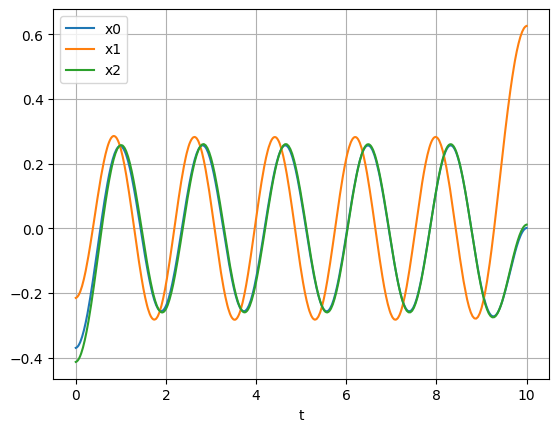

In [13]:
def plot_samples(samples):
        for i in range(samples.shape[0]):
            plt.plot(time_span, samples[i, :], label=f'x{i}')
        plt.legend(loc='best')
        plt.xlabel('t')
        plt.grid()
        plt.show()

plot_samples(sampled[:3, :])

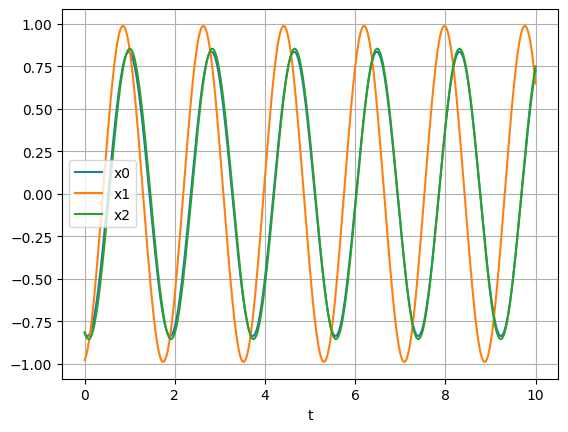

In [14]:
plot_samples(xs[:3, :])

The loss is the $L_{\text{LA}}$ is the note. That is, the loss by minimizing which least action principle is induced. Conventionally, we call the sampled data as "fantacy data", as if they are dreamed by the model.

We have to twist the hyper-parameters in the `langevin_sampling` so that the loss value are proper for training (for example, it should not be `NaN`). And it is positive in most trials, otherwise bug shall exist.

In [15]:
@tf.function
def get_loss(xs, ts):
    fantacy = langevin_sampling(lambda x: model(x, ts), xs, 1e-1, 1e-8, 10)
    return tf.reduce_mean(model(xs, ts)) - tf.reduce_mean(model(fantacy, ts))

get_loss(xs, ts)

<tf.Tensor: shape=(), dtype=float32, numpy=0.05295968>

In [16]:
def get_train_step(model, optimizer):
    step = tf.Variable(0, dtype=tf.int32, trainable=False)

    @tf.function
    def train_step_fn(batch):
        with tf.GradientTape() as tape:
            loss_value = get_loss(batch, ts)
        grads = tape.gradient(loss_value, model.couplings)
        optimizer.apply_gradients(zip(grads, model.couplings))
        step.assign_add(1)
        return loss_value

    return train_step_fn, step

optimizer = keras.optimizers.adam_v2.Adam()
train_step, step = get_train_step(model, optimizer)

In [17]:
train_ds = train_ds.shuffle(1000).repeat(800).batch(BATCH_SIZE)
process_bar = keras.utils.generic_utils.Progbar(len(train_ds))
for batch in train_ds:
    loss_value = train_step(batch)
    process_bar.update(current=tf.cast(step, tf.float32),
                       values=[('loss', loss_value)])

61250/61250 [==============================] - 997s 16ms/step - loss: 0.0096


It can be found that the trained couplings match the target on the lower order term (the first coupling), but will not match on higher order terms.

In [18]:
model.couplings

ListWrapper([<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=10.128949>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=17.018562>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.974481>])

Let compare the sampled data from the trained model/action with the real/simulation data. We will find that they match perfectly.

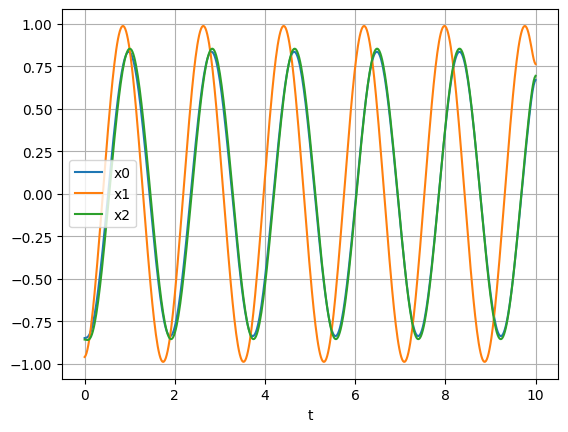

In [19]:
sampled = langevin_sampling(lambda xs: model(xs, ts), xs, 1e-1, 1e-8, 10)
plot_samples(sampled[:3, :])

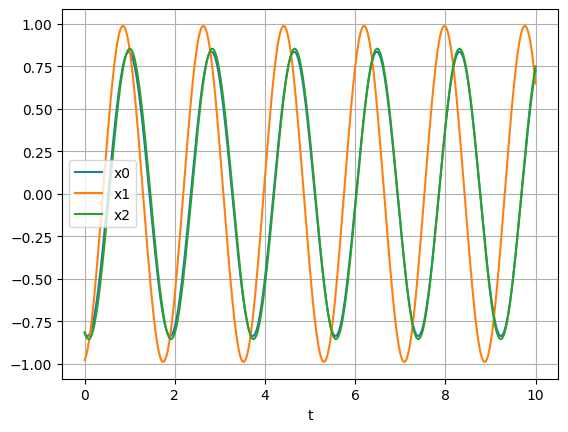

In [20]:
plot_samples(xs[:3, :])

## Evaluation

To evaluate the result, simply knowing that the fitted couplings match the target ones is not enough, since we should not know the target couplings.

A more proper way of evalution is testing if the real data sit in the local minima of the trained action. To test this, we evolve the real data (the evaluation data that are absent in the training) by zero-$T$ Langevin dynamics, $\textrm{d}x = -\nabla S(x) \textrm{d}t$, a process called "relaxation". With sufficient iteration steps, the data shall not leave their original value, the minima of the action $S$. We will find that it does be so.

In [21]:
relaxed = langevin_sampling(lambda xs: model(xs, ts), eval_data, 1e-3, 0., 5000)
relaxed

<tf.Tensor: shape=(200, 501), dtype=float32, numpy=
array([[-0.89504063, -0.89246106, -0.8872826 , ...,  0.56195605,
         0.5739592 ,  0.5800122 ],
       [-0.9283681 , -0.922481  , -0.91077226, ...,  0.94877946,
         0.9443967 ,  0.9421262 ],
       [-0.9229711 , -0.92094845, -0.9168633 , ...,  0.58666676,
         0.5988764 ,  0.60503274],
       ...,
       [-0.25266814, -0.24959157, -0.24349207, ..., -0.15144472,
        -0.14580594, -0.1429463 ],
       [ 0.07144836,  0.07314918,  0.07650445, ...,  0.0146252 ,
         0.01836953,  0.0202637 ],
       [ 0.36558804,  0.36374018,  0.36005872, ...,  0.34333628,
         0.34119374,  0.3400951 ]], dtype=float32)>

Now, we compare the data of relaxation and the original evaluation data. They match perfectly, except for the points at the boundaries.

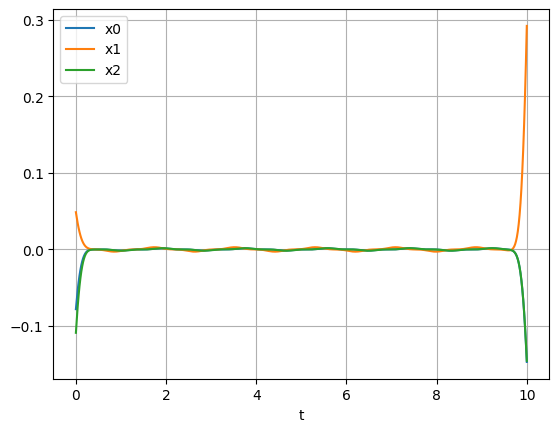

In [22]:
plot_samples((relaxed - eval_data)[:3, :])

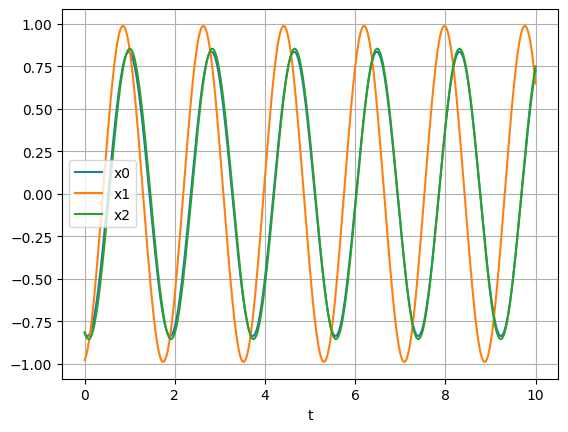

In [23]:
plot_samples(eval_data[:3, :])

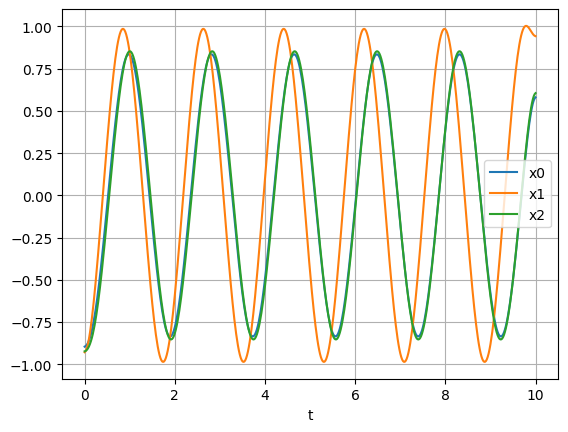

In [24]:
plot_samples(relaxed[:3, :])

## Conclusion

We find that, by data fitting, the least action principle is revealed perfectly on the lower order couplings. The higher order couplings of the trained will not match the target. But, if you compare the plots between the data of relaxation and the original simulation data, the result is still perfect. The result is insensitive to the higher order couplings. Because of this, and the existence of numerical errors, the higher order couplings do not match the target.

So, we find that data fitting does induce the least action principle. But, the method fails at searching for the correct parameters of the insensitive terms. Because of numerical errors, this failure is inevitable.